In [1]:
import pandas as pd
import requests
import ipywidgets as widgets
from IPython.display import display
from typing import List
from space2stats_client import Space2StatsClient
import geopandas as gpd
import urllib.request
from urllib.parse import urljoin
import json
import matplotlib.pyplot as plt
from shapely import from_geojson

# Init Client
client = Space2StatsClient()

# Base URLs and endpoints
FIELDS_ENDPOINT = "https://space2stats.ds.io/fields"
COLLECTION_URL = "https://raw.githubusercontent.com/worldbank/DECAT_Space2Stats/refs/heads/main/space2stats_api/src/space2stats_ingest/METADATA/stac/space2stats-collection/collection.json"

In [2]:

class Space2StatsFieldSelector:
    """Interactive field selector for Space2Stats API."""
    
    def __init__(self):
        self.all_fields = []
        self.field_groups = {}
        self.checkboxes = {}
        self.output = widgets.Output()
        self.field_descriptions = {}  # Store field descriptions from STAC
        self.field_to_group = {}  # Mapping from field to group name
        
    def load_data(self):
        """Load data from API and STAC collection."""
        with self.output:
            print("Loading data from API and STAC collection...")
            
            # Load fields from API
            try:
                response = requests.get(FIELDS_ENDPOINT)
                if response.status_code == 200:
                    self.all_fields = response.json()
                    print(f"✓ {len(self.all_fields)} fields loaded from API")
                else:
                    print(f"✗ Error loading fields: {response.text}")
                    return
            except Exception as e:
                print(f"✗ Error connecting to API: {e}")
                return
                
            # Group fields by STAC items
            self._group_fields_by_stac_items()
    
    def _group_fields_by_stac_items(self):
        """Group fields by their source STAC items."""
        with self.output:
            try:
                # Load collection JSON directly
                with urllib.request.urlopen(COLLECTION_URL) as url:
                    collection_data = json.loads(url.read().decode())
                    print(f"✓ Collection loaded: {collection_data.get('id')}")
                    
                    # Get item links
                    items_links = [link for link in collection_data.get('links', []) 
                                  if link.get('rel') == 'item']
                    
                    # Get the base URL for resolving relative paths
                    collection_base_url = COLLECTION_URL.rsplit('/', 1)[0] + '/'
                    
                    # Initialize field groups dictionary
                    self.field_groups = {}
                    self.field_descriptions = {}
                    self.field_to_group = {}
                    
                    # Process each item link
                    for item_link in items_links:
                        # Get the relative href and resolve to absolute URL
                        relative_href = item_link.get('href')
                        item_url = urljoin(collection_base_url, relative_href)
                        
                        try:
                            # Load item JSON
                            with urllib.request.urlopen(item_url) as url:
                                item_data = json.loads(url.read().decode())
                                
                            # Use the item's title or name as the group name
                            group_name = item_link.get('title') or item_data.get('properties', {}).get('name', item_data.get('id'))
                            
                            # Get the table columns from the item properties
                            if "table:columns" in item_data.get('properties', {}):
                                columns = item_data['properties']['table:columns']
                                
                                # Extract field names and descriptions
                                fields_in_item = []
                                for column in columns:
                                    field_name = column.get("name")
                                    
                                    if field_name and field_name.lower() in [f.lower() for f in self.all_fields]:
                                        # Find the exact field name with correct case
                                        exact_field = next((f for f in self.all_fields if f.lower() == field_name.lower()), None)
                                        if exact_field:
                                            fields_in_item.append(exact_field)
                                            # Store description for tooltip
                                            self.field_descriptions[exact_field] = column.get("description", "")
                                            # Map field to group
                                            self.field_to_group[exact_field] = group_name
                                
                                if fields_in_item:
                                    self.field_groups[group_name] = fields_in_item
                        
                        except Exception as e:
                            print(f"Error processing STAC item {item_url}: {e}")
                    
                    # Add an "Uncategorized" group for fields not found in any STAC item
                    categorized_fields = [field for group in self.field_groups.values() for field in group]
                    uncategorized_fields = [field for field in self.all_fields if field not in categorized_fields]
                    
                    if uncategorized_fields:
                        self.field_groups["Uncategorized"] = uncategorized_fields
                        
                    
            except Exception as e:
                print(f"Error grouping fields by STAC items: {e}")
                import traceback
                traceback.print_exc()
                
                # If STAC processing fails, put all fields in one group
                self.field_groups = {"All Fields": self.all_fields}
                print("✓ Fallback: All fields added to a single group")
    
    def create_ui(self):
        """Create the UI for field selection."""
        if not self.field_groups:
            return widgets.HTML("No field groups available. Please check the output for errors.")
            
        # Create accordion for field groups
        accordion = widgets.Accordion()
        children = []
        
        # Create checkboxes for each group
        for group, fields in self.field_groups.items():
            # Create a VBox of checkboxes for this group
            group_checkboxes = []
            
            # Add "Select All" checkbox
            select_all = widgets.Checkbox(
                value=False,
                description=f'Select All ({len(fields)})',
                indent=False,
                layout=widgets.Layout(width='300px')
            )
            
            # Individual field checkboxes
            field_checkboxes = []
            for field in sorted(fields):
                description = field
                tooltip = self.field_descriptions.get(field, "")
                
                checkbox = widgets.Checkbox(
                    value=False,
                    description=description,
                    indent=False,
                    layout=widgets.Layout(width='400px'),
                    tooltip=tooltip
                )
                field_checkboxes.append(checkbox)
            
            # Store checkboxes for later retrieval
            self.checkboxes[group] = {
                'select_all': select_all,
                'fields': {field: checkbox for field, checkbox in zip(sorted(fields), field_checkboxes)}
            }
            
            # Link "Select All" to toggle all checkboxes in the group
            def make_select_all_handler(group_name):
                def select_all_handler(change):
                    if change['type'] == 'change' and change['name'] == 'value':
                        for checkbox in self.checkboxes[group_name]['fields'].values():
                            checkbox.value = change['new']
                return select_all_handler
            
            select_all.observe(make_select_all_handler(group), names='value')
            
            # Create the group's widget
            group_widget = widgets.VBox([select_all] + field_checkboxes)
            children.append(group_widget)
        
        # Set up the accordion
        accordion.children = children
        for i, group in enumerate(self.field_groups.keys()):
            accordion.set_title(i, f"{group} ({len(self.field_groups[group])})")
        
        # Create a button to get selected fields
        get_selected_button = widgets.Button(
            description='Get Selected Fields',
            button_style='primary',
            tooltip='Get the list of selected fields'
        )
        
        # Output area for selected fields
        selected_output = widgets.Output()
        
        def on_get_selected_clicked(b):
            selected = self.get_selected_fields()
            with selected_output:
                selected_output.clear_output()
                if selected:
                    print(f"Selected {len(selected)} fields:")
                    print(selected)
                else:
                    print("No fields selected")
        
        get_selected_button.on_click(on_get_selected_clicked)
        
        # Combine all widgets
        ui = widgets.VBox([
            accordion,
            get_selected_button,
            selected_output
        ])
        
        return ui
    
    def get_selected_fields(self) -> List[str]:
        """Get the list of selected fields."""
        selected = []
        for group, checkboxes in self.checkboxes.items():
            for field, checkbox in checkboxes['fields'].items():
                if checkbox.value:
                    selected.append(field)
        return selected
    
    def display(self):
        """Display the field selector UI."""
        self.load_data()
        ui = self.create_ui()
        display(widgets.VBox([self.output, ui]))

# Create and display the field selector
field_selector = Space2StatsFieldSelector()
field_selector.display()

In [3]:
# Get the selected fields
selected_fields = field_selector.get_selected_fields()

<Axes: >

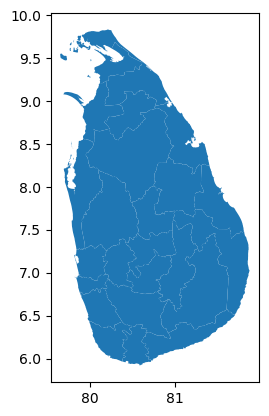

In [4]:
ISO3 = "LKA" # Sri Lanka 
ADM = "ADM2" # Level 2 administrative boundaries
adm_boundaries = client.fetch_admin_boundaries(ISO3, ADM)
adm_boundaries.plot()

In [5]:
# Get available topics/datasets
df = client.get_summary(
    gdf=adm_boundaries,
    spatial_join_method="centroid",
    fields=selected_fields,
    geometry="polygon"
)

# Convert to gdf
df["geometry"] = df["geometry"].apply(lambda geom: from_geojson(geom))
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,index_gdf,index_h3,hex_id,geometry,sum_viirs_ntl_2012,sum_viirs_ntl_2013,sum_viirs_ntl_2014,sum_viirs_ntl_2015,sum_viirs_ntl_2016
0,Jaffna District,LK-41,46371173B9817749849456,LKA,ADM2,0,0,86611a51fffffff,"POLYGON ((79.69894 9.51228, 79.69977 9.54764, ...",72.250000,65.220001,81.540001,121.800003,85.169998
1,Jaffna District,LK-41,46371173B9817749849456,LKA,ADM2,0,1,8661a9927ffffff,"POLYGON ((79.97414 9.76997, 79.97501 9.80537, ...",100.569992,93.199997,123.900002,137.520004,112.500000
2,Jaffna District,LK-41,46371173B9817749849456,LKA,ADM2,0,2,8661ad037ffffff,"POLYGON ((80.50855 9.5413, 80.50948 9.57679, 8...",74.790001,72.110001,95.750000,123.219994,98.060005
3,Jaffna District,LK-41,46371173B9817749849456,LKA,ADM2,0,3,8661ad0cfffffff,"POLYGON ((80.27109 9.65499, 80.27199 9.69045, ...",116.320000,100.550003,128.309998,159.850006,127.220001
4,Jaffna District,LK-41,46371173B9817749849456,LKA,ADM2,0,4,8661ad0dfffffff,"POLYGON ((80.30245 9.70729, 80.30336 9.74275, ...",89.559998,74.669998,98.910004,103.789993,95.520004


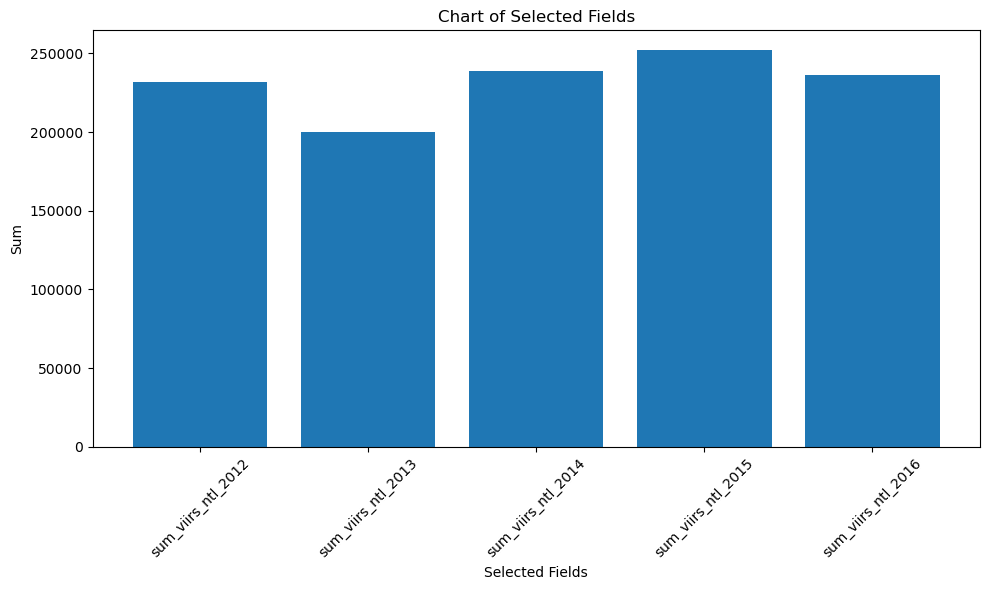

In [6]:
import matplotlib.pyplot as plt

# Sum the values for each selected field (if numeric)
summary_data = gdf[selected_fields].sum()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(summary_data.index, summary_data.values)
plt.xlabel('Selected Fields')
plt.ylabel('Sum' if 'summary_data' in locals() else 'Count')
plt.title('Chart of Selected Fields')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# Now create your risk map
nlt_2012 = gdf.explore(
    column="sum_viirs_ntl_2012",
    tooltip=[],
    cmap="OrRd",
    legend=True,
    scheme="quantiles",
    legend_kwds=dict(colorbar=True, caption="sum_viirs_ntl_2012", interval=False),
    style_kwds=dict(weight=0.5, fillOpacity=0.8),
    name="sum_viirs_ntl_2012",
)

nlt_2012